In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

import numpy as np
from pythtb import *
from wpythtb import Bloch, K_mesh, Wannier
import models

import matplotlib.pyplot as plt
from itertools import product

/Users/treycole/Repos/WanPy/dev


In [2]:
# tight-binding parameters
delta = 1
t = 1
t2 = -0.3

n_super_cell = 2
model = models.Haldane(delta, t, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])
model.onsite = model.set_onsite(0.5, ind_i = 2, mode='add')

#############

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)
lat_vecs = model.get_lat()
recip_lat_vecs = model.get_recip_lat_vecs()
orb_vecs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)

nkx = nky = 40
bloch_wfs = Bloch(model, nkx, nky)
bloch_wfs.solve_model()
chern = bloch_wfs.chern_num()

# model_str = f'C={chern:.1f}_Delta={delta}_t={t}_t2={t2}'

print(f"Low energy sites: {low_E_sites}")
print(f"High energy sites: {high_E_sites}")
print(f"Chern # occupied: {chern: .1f}")

(40, 40, 8, 8)
(40, 40, 8, 8)
(40, 40, 4, 8)
(2, 2, 40, 40)
Low energy sites: [0 2 4 6]
High energy sites: [1 3 5 7]
Chern # occupied:  1.0+0.0j


(<Figure size 640x480 with 2 Axes>, <Axes: ylabel='Energy $E(\\mathbf{{k}})$'>)

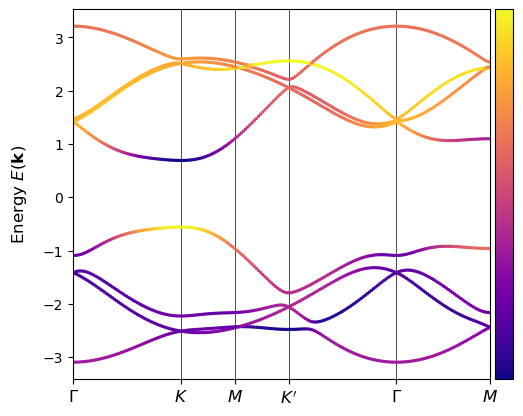

In [3]:
k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 101, report=False)

model.plot_bands(k_path, k_label=k_label, nk=201, scat_size=2, proj_orb_idx=high_E_sites, cmap='plasma')

In [4]:
k_mesh = K_mesh(model, nkx, nky)

flat_mesh = k_mesh.gen_k_mesh(endpoint=False)
sq_mesh = k_mesh.gen_k_mesh(flat=False, endpoint=False)

mesh_Cart = sq_mesh @ recip_lat_vecs

KX = mesh_Cart[:, :, 0]
KY = mesh_Cart[:, :, 1]

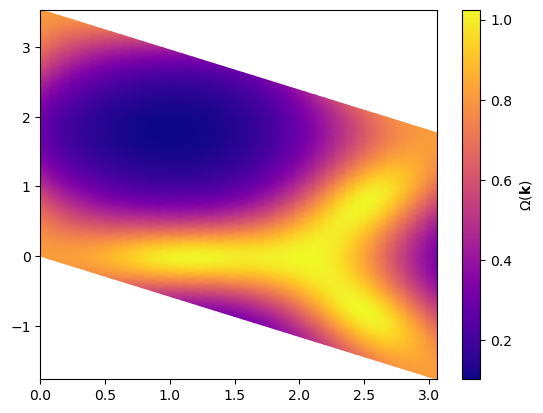

In [28]:
u_wfs_2d = wf_array(model, [nkx+1, nky+1])
u_wfs_2d.solve_on_grid([0, 0])

berry_flux = u_wfs_2d.berry_flux([i for i in range(n_occ)], individual_phases=True)
N_cells = np.prod([ nk for nk in (nkx, nky)])
dV = model.get_recip_vol()/N_cells

im = plt.pcolormesh(KX, KY, berry_flux/dV, cmap='plasma', shading='gouraud')
plt.colorbar(label=r'$\Omega(\mathbf{k})$')

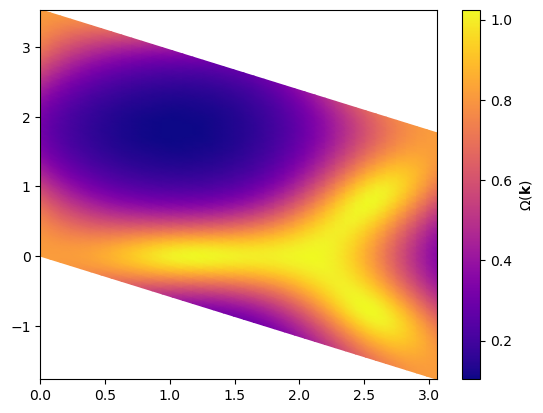

In [32]:
bcurv_kubo = model.berry_curvature(flat_mesh, occ_idxs=np.arange(n_occ))
bcurv_kubo = np.trace(bcurv_kubo, axis1=-1, axis2=-2)[0, 1].reshape(nkx, nky)

im = plt.pcolormesh(KX, KY, bcurv_kubo.real, cmap='plasma', shading='gouraud')
plt.colorbar(label=r'$\Omega(\mathbf{k})$')

(40, 40, 8, 8)
(40, 40, 4, 8)
(2, 2, 40, 40)


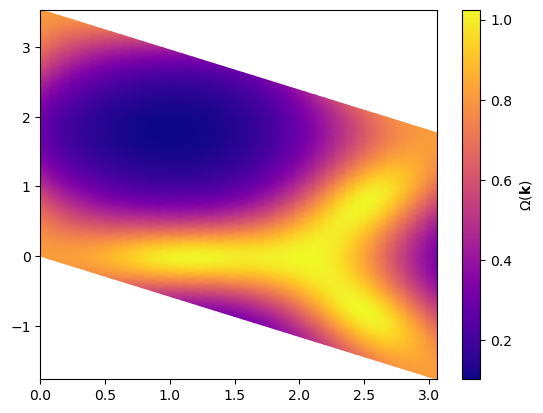

In [33]:
Berry_curv = bloch_wfs.berry_curv(dirs=(0,1), state_idx=np.arange(n_occ))
im = plt.pcolormesh(KX, KY, Berry_curv.real, cmap='plasma', shading='gouraud')
plt.colorbar(label=r'$\Omega(\mathbf{k})$')

In [35]:
# non-Abelian
bcurv_kubo = model.berry_curvature(flat_mesh, occ_idxs=np.arange(n_occ))
bcurv_kubo = bcurv_kubo.reshape(2, 2, nkx, nky, n_occ, n_occ)
bcurv_plaq = bloch_wfs.berry_curv(state_idx=np.arange(n_occ), non_abelian=True)

# Abelian
bcurv_abel = bloch_wfs.berry_curv(state_idx=np.arange(n_occ), non_abelian=False)

print(bcurv_kubo.shape, bcurv_abel.shape, bcurv_plaq.shape)

(40, 40, 8, 8)
(40, 40, 4, 8)
(2, 2, 40, 40, 4, 4)
(40, 40, 8, 8)
(40, 40, 4, 8)
(2, 2, 40, 40)
(2, 2, 40, 40, 4, 4) (2, 2, 40, 40) (2, 2, 40, 40, 4, 4)


In [39]:
V_BZ = model.get_recip_vol()
dk_sq = V_BZ / np.prod([nk for nk in (nkx, nky)])

Chern_kubo = np.sum(np.trace(bcurv_kubo, axis1=-1, axis2=-2)[0, 1]) * dk_sq / (2 * np.pi)
Chern_plaq = np.sum(np.trace(bcurv_plaq, axis1=-1, axis2=-2)[0, 1]) * dk_sq / (2 * np.pi)

print(f"Chern kubo: {Chern_kubo.real}")
print(f"Chern plaquette: {Chern_plaq.real}")

Chern kubo: 0.9999999999999999
Chern plaquette: 0.9999999999999979


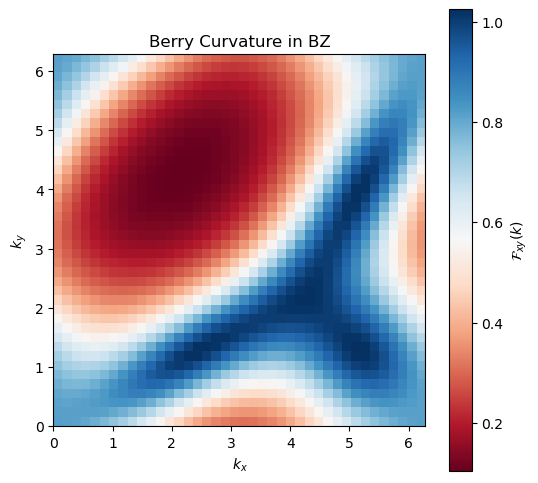

In [16]:
import matplotlib.pyplot as plt

# Extract Berry curvature for visualization
F_xy = np.trace(bcurv_kubo, axis1=-2, axis2=-1)[0, 1].real

plt.figure(figsize=(6,6))
plt.imshow(F_xy.T, origin='lower', cmap='RdBu', extent=[0, 2*np.pi, 0, 2*np.pi])
plt.colorbar(label=r'$\mathcal{F}_{xy}(k)$')
plt.xlabel("$k_x$")
plt.ylabel("$k_y$")
plt.title("Berry Curvature in BZ")
plt.show()

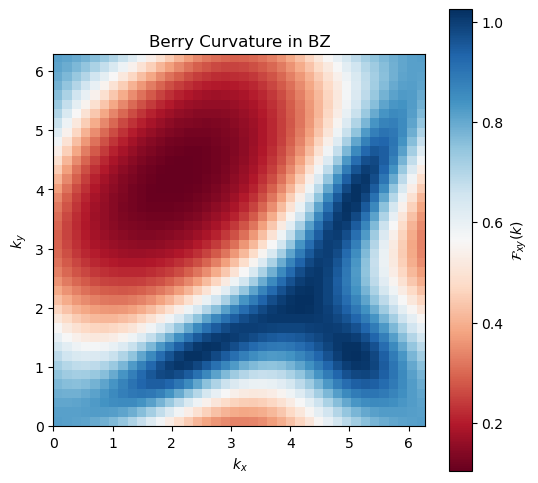

In [17]:
import matplotlib.pyplot as plt

# Extract Berry curvature for visualization
F_xy = np.trace(bcurv_plaq, axis1=-2, axis2=-1)[0, 1].real

plt.figure(figsize=(6,6))
plt.imshow(F_xy.T, origin='lower', cmap='RdBu', extent=[0, 2*np.pi, 0, 2*np.pi])
plt.colorbar(label=r'$\mathcal{F}_{xy}(k)$')
plt.xlabel("$k_x$")
plt.ylabel("$k_y$")
plt.title("Berry Curvature in BZ")
plt.show()